In [1]:
import os

from langgraph.graph import StateGraph, START, END


from Nodes.generate_component import *
from Nodes.generate_layout import *

# os.environ["LANGCHAIN_TRACING_V2"] = os.getenv("CUSTOM_TRACING_V2", "true")
# os.environ["LANGCHAIN_ENDPOINT"] = os.getenv("CUSTOM_ENDPOINT", "https://api.smith.langchain.com")
# os.environ["LANGCHAIN_PROJECT"] = os.getenv("CUSTOM_PROJECT", "CFOLytics_reportgenerator")

##########################################
# Build the specialized component subgraph
##########################################
component_subgraph = StateGraph(SpecializedComponentState)

component_subgraph.add_node("component_selector", component_selector)
component_subgraph.add_node("generate_chart_component", generate_chart_component)
component_subgraph.add_node("generate_table_component", generate_table_component)
component_subgraph.add_node("generate_waterfall_component", generate_waterfall_component)
component_subgraph.add_node("generate_tile_component", generate_tile_component)
component_subgraph.add_node("generate_generic_component", generate_generic_component)

component_subgraph.add_edge(START, "component_selector")

component_subgraph.add_conditional_edges(
    "component_selector",
    selector_routing,
    [
        "generate_chart_component",
        "generate_table_component",
        "generate_waterfall_component",
        "generate_tile_component",
        "generate_generic_component"
    ]
)

# Each specialized node ends immediately
component_subgraph.add_edge("generate_chart_component", END)
component_subgraph.add_edge("generate_table_component", END)
component_subgraph.add_edge("generate_waterfall_component", END)
component_subgraph.add_edge("generate_tile_component", END)
component_subgraph.add_edge("generate_generic_component", END)

# Compile subgraph
generate_component_subchart = component_subgraph.compile()

from Nodes.mainchart_helper_functions import *


from Classes.state_classes import ListSubchartState
from Nodes.generate_list import *


subgraph = StateGraph(ListSubchartState)

subgraph.add_node("check_if_list_exists", check_if_list_exists)
subgraph.add_node("return_existing_list", return_existing_list)
subgraph.add_node("check_dynamic_or_fixed", check_dynamic_or_fixed)
subgraph.add_node("create_fixed_list", create_fixed_list)
subgraph.add_node("create_dynamic_list", create_dynamic_list)

subgraph.add_edge(START, "check_if_list_exists")


subgraph.add_conditional_edges("check_if_list_exists", list_exists_routing,
                               ["return_existing_list", "check_dynamic_or_fixed"])
subgraph.add_edge("return_existing_list", END)


subgraph.add_conditional_edges("check_dynamic_or_fixed", dynamic_or_fixed_routing,
                               ["create_dynamic_list", "create_fixed_list"])
subgraph.add_edge("create_dynamic_list", END)
subgraph.add_edge("create_fixed_list", END)

# Compile the subchart
generate_list_subchart = subgraph.compile()

##########################
# MAIN GRAPH
##########################
graph = StateGraph(OverallState)

graph.add_node("generate_conceptualdesign", generate_conceptualdesign)
graph.add_node("generate_layout", generate_layout)
graph.add_node("generate_component_subchart", generate_component_subchart)
graph.add_node("update_json_layout", update_json_layout)
graph.add_node("gatheruniquelists", gatheruniquelists)
graph.add_node("generate_list_subchart", generate_list_subchart)  # Subchart for lists
graph.add_node("consolidate_lists_to_layout", consolidate_lists_to_layout)

graph.add_edge(START, "generate_conceptualdesign")
graph.add_edge("generate_conceptualdesign", "generate_layout")

# After we have the base layout and extracted all 'Components',
# route each component to the specialized subchart
graph.add_conditional_edges("generate_layout", continue_to_components, ["generate_component_subchart"])

# Then from the specialized subchart, we go to update_json_layout
graph.add_edge("generate_component_subchart", "update_json_layout")

graph.add_edge("update_json_layout", "gatheruniquelists")

graph.add_conditional_edges("gatheruniquelists", continue_to_lists, ["generate_list_subchart"])

graph.add_edge("generate_list_subchart", "consolidate_lists_to_layout")
graph.add_edge("consolidate_lists_to_layout", END)

# Compile the main graph
app = graph.compile()

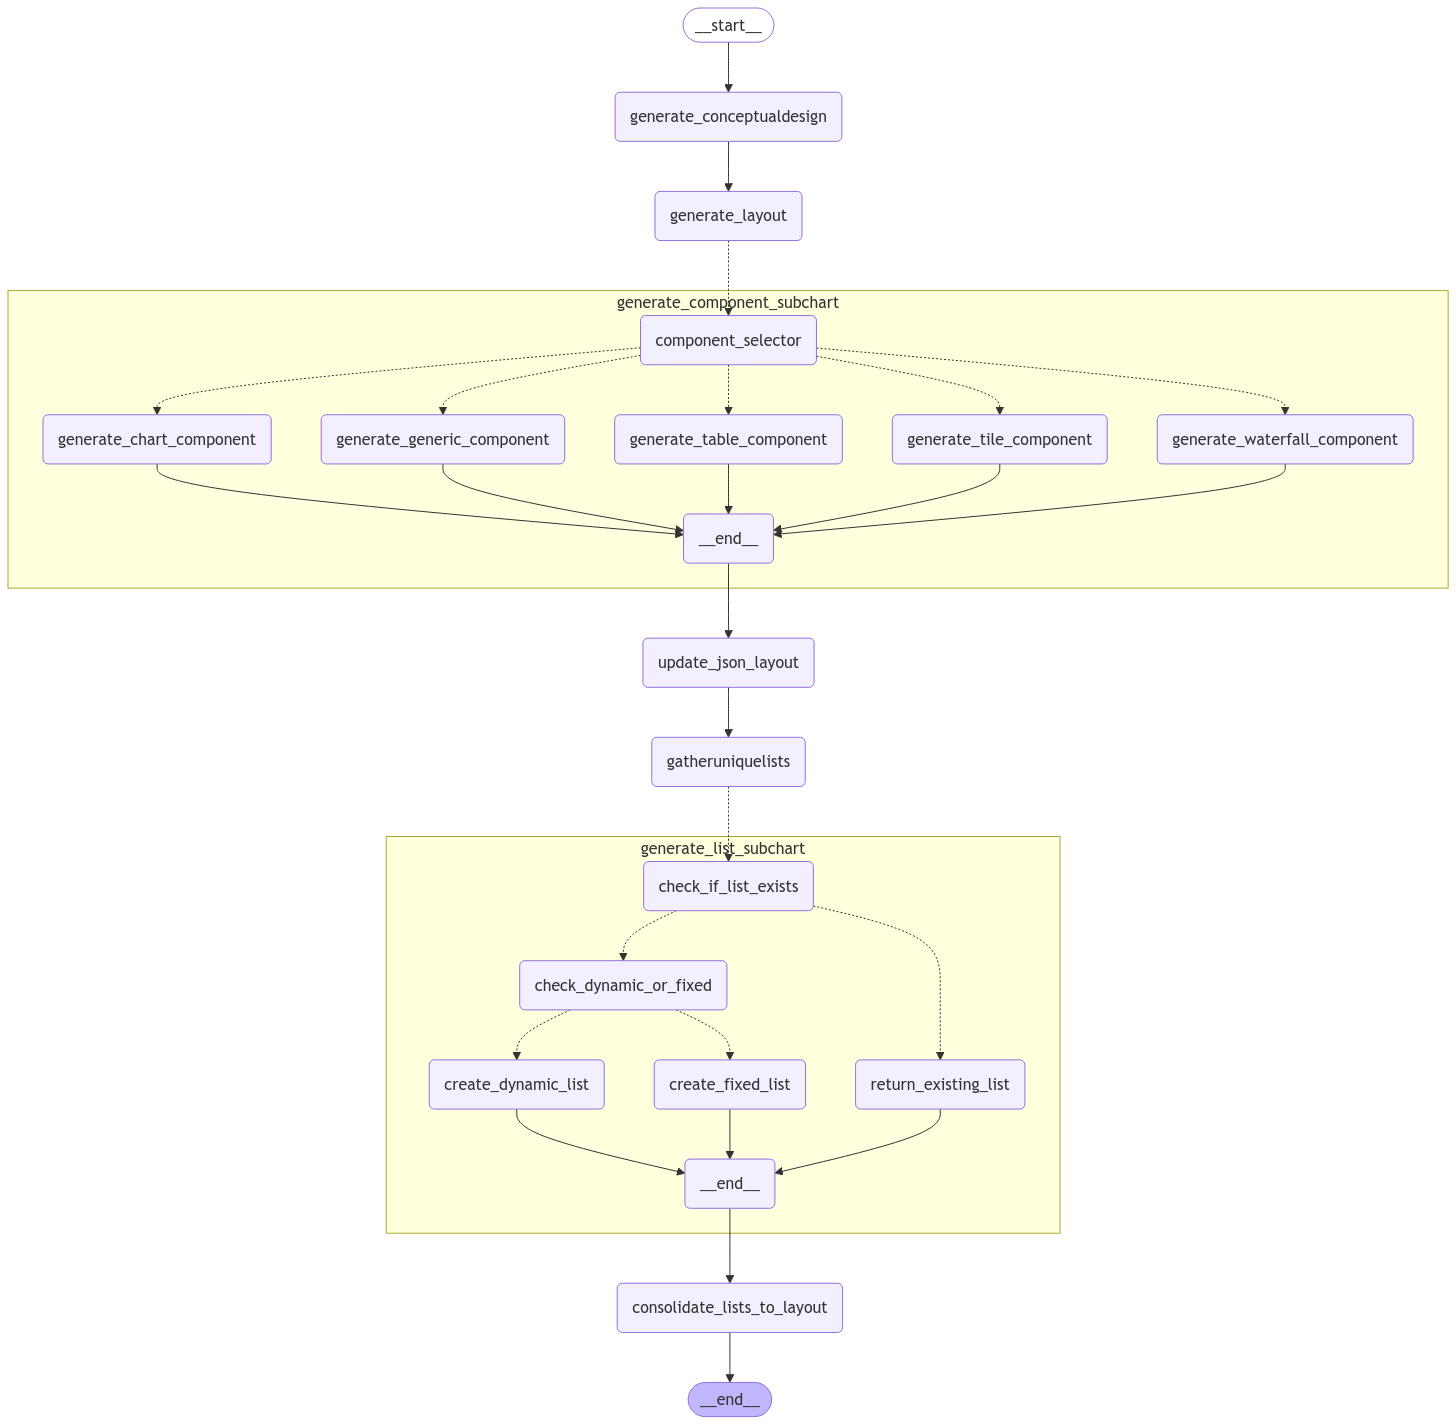

In [2]:
from IPython.display import Image
Image(app.get_graph(xray=1).draw_mermaid_png())


In [3]:
import json
from typing import Annotated, List


with open("sample.json", "r", encoding="utf-8") as f:
    state_data = json.load(f)
    state = OverallState(state_data)
    result_state = app.invoke(state)

final_json = json.dumps(result_state["JsonLayout"], ensure_ascii=False, separators=(",", ":")).replace("True", "true").replace("False", "false")

print(final_json)


[{"name":"Category","alias":"Category","dimensionContent":[{"ID":1,"Name":"Actual"},{"ID":2,"Name":"Budget"},{"ID":3,"Name":"Forecast Jun"}]}]
{"reportTitle":"Profit and Loss Report","numberFormat":{"currency":"USD","scale":"thousands","decimals":0},"layout":{"gridColumns":{"sm":1,"md":1,"lg":8},"rows":[{"columns":[{"colSpan":{"sm":1,"md":1,"lg":8},"components":[{"id":"C1","type":"ReportTable","title":"Profit and Loss Statement","AI_Generation_Description":"A table showing the profit and loss statement on the rows with Account, and Actual, Budget, Variance, and Variance Bar on the columns. The table should have drilldown capabilities for the main accounts.","config":{"selectRow":true,"firstColumnWidth":200,"lists":[{"listReference":"rowsList","list":"ProfitAndLossAccounts","createDescription":"A formatted profit and loss statement to be used on table rows with main accounts and drilldown capabilities."},{"listReference":"columnsList","list":"ActualBudgetVarianceVarianceBar","createDesc